In [13]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [18]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    return one_by_one

In [21]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features = one_by_one(filtersNumber, embedding_dropout)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [10]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 1:49 - loss: 0.1606 - acc: 0.9389102124/102124 [==============================] - 201s 2ms/step - loss: 0.1025 - acc: 0.9619 - val_loss: 0.0480 - val_acc: 0.9824
Epoch 2/32
  5568/102124 [>.............................] - ETA: 2:52 - loss: 0.0504 - acc: 0.9815102080/102124 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9806102124/102124 [==============================] - 197s 2ms/step - loss: 0.0526 - acc: 0.9806 - val_loss: 0.0454 - val_acc: 0.9833
roc-auc: 0.9869 - roc-auc_val: 0.9835                                                                                                    
Epoch 3/32
102124/102124 [==============================] - 197s 2ms/step - loss: 0.0480 - acc: 0.9820 - val_loss: 0.0422 - val_acc: 0.9838==>.] - ETA: 0s - loss: 0.0480 - acc: 0.982
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 2:25 - loss: 0.0452 - ac

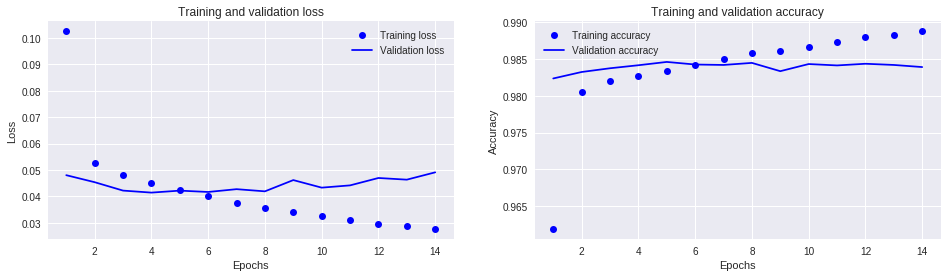

In [11]:
plot_history(history)

In [12]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 24s 751us/step
([0.046024657765264924, 0.9847407030924797], 0.9880884328582592)


In [10]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 20800/102124 [=====>........................] - ETA: 3:03 - loss: 0.1775 - acc: 0.9308 55168/102124 [===============>..............] - ETA: 1:42 - loss: 0.1080 - acc: 0.9596 91712/102124 [=========================>....] - ETA: 22s - loss: 0.0885 - acc: 0.9673102124/102124 [==============================] - 238s 2ms/step - loss: 0.0850 - acc: 0.9686 - val_loss: 0.0457 - val_acc: 0.9828
Epoch 2/32
  9408/102124 [=>............................] - ETA: 3:17 - loss: 0.0536 - acc: 0.9802 45248/102124 [============>.................] - ETA: 2:00 - loss: 0.0532 - acc: 0.9801 81952/102124 [=======================>......] - ETA: 42s - loss: 0.0519 - acc: 0.9807102124/102124 [==============================] - 236s 2ms/step - loss: 0.0518 - acc: 0.9807 - val_loss: 0.0470 - val_acc: 0.9824
roc-auc: 0.9878 - roc-auc_val: 0.9837                                                                                                    
Epoch 3/32


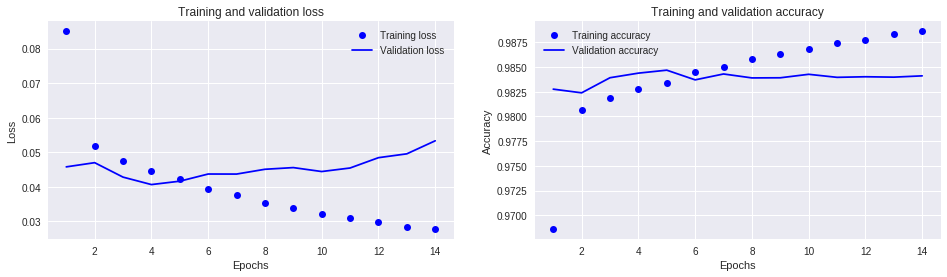

In [11]:
plot_history(history)

In [12]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 24s 764us/step
([0.050042531947416834, 0.9843855944001785], 0.9872222218751873)


In [22]:
history = train_with_cv(model, batchSize=128, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 85888/102124 [========================>.....] - ETA: 26s - loss: 0.1486 - acc: 0.9438102124/102124 [==============================] - 183s 2ms/step - loss: 0.1348 - acc: 0.9493 - val_loss: 0.0613 - val_acc: 0.9779
Epoch 2/32
 50048/102124 [=============>................] - ETA: 1:24 - loss: 0.0549 - acc: 0.9801102124/102124 [==============================] - 181s 2ms/step - loss: 0.0542 - acc: 0.9802 - val_loss: 0.0562 - val_acc: 0.9813
roc-auc: 0.9582 - roc-auc_val: 0.9582                                                                                                    
Epoch 3/32
 22528/102124 [=====>........................] - ETA: 2:08 - loss: 0.0498 - acc: 0.9816102124/102124 [==============================] - 181s 2ms/step - loss: 0.0498 - acc: 0.9814 - val_loss: 0.0427 - val_acc: 0.9837
Epoch 4/32
 25856/102124 [======>.......................] - ETA: 2:03 - loss: 0.0452 - acc: 0.9827102124/102124 [==================

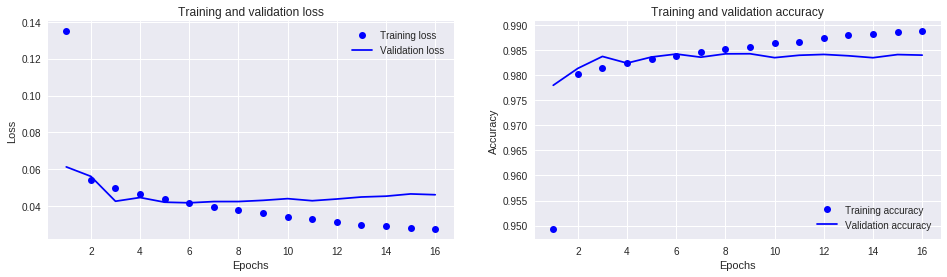

In [23]:
plot_history(history)

In [24]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 24s 750us/step
([0.044071976762742375, 0.9844534822117661], 0.9889365926147416)
